In [1]:
import sys
from ephys import rasters, core, events
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
#reload(rasters)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ephys import core, events, rasters
import numpy as np
import matplotlib.pyplot as plt
from oe_pipeline import mdaio

In [3]:
block_path = '/mnt/cube/nyoni-raw/test_data/201901300906-B970-block-9-AP-1250-ML-750-Z-1750'
#block_path = 'mnt/cube/Nasim/1_Receptive Field_MNE/2_B952/B952_2_Pen01_Lft_AP750_ML1750__Site01_Z1500__B952_cat_P01_S01_2';


spikes = core.load_spikes(block_path)
trials = events.oe_load_trials(block_path)
fs = core.load_fs(block_path)
clusters = core.load_clusters(block_path)
#clusters['quality'] = ['good'] * 43

In [4]:
stims = trials['stimulus'].unique()
nstims = len(stims)

In [5]:
#print(stims)
#print(clusters['cluster'])
#print(spikes)
print(trials)
#print(stims)

   trial_start  trial_end  time_samples  stimulus_end                 stimulus
0       168211    1169904        169604       1170620  rmp5ms_G122-29.wav.sine


# Get stimulus information

In [6]:
### Confirm with Michael on how to find start and end time sof stimulus
import pandas as pd
d = []
for s in stims:
    ind = []
    ind = np.where(np.array(trials['stimulus']) == s)
    d.append({'name':s, 'start_times':[trials['time_samples'][i] for i in ind], 'end_times':[trials['stimulus_end'][i] for i in ind],
              'trial_start':[trials['trial_start'][i] for i in ind], 'trial_end':[trials['trial_end'][i] for i in ind],
              'ntrials':(list(trials['stimulus'])).count(s)})
stim_data = pd.DataFrame(d)

In [7]:
print(stim_data)

     end_times                     name  ntrials start_times    trial_end  \
0  [[1170620]]  rmp5ms_G122-29.wav.sine        1  [[169604]]  [[1169904]]   

  trial_start  
0  [[168211]]  


# Get rasters

In [8]:
def plot_raster_cell_stim(spikes, trials, clusterID,
                          stim, period, rec, fs, ax=None, stim_ref='stim', **kwargs):
    '''
    Plots a spike raster for a single cell and stimulus
    Parameters
    ------
    spikes : pandas dataframe
        spike dataframe from core
    trials : pandas dataframe
        trials dataframe from events
    clusterID : int
        ID number of the cluster you wish to make the raster for
    stim : str
        Name of the stimulus you wish to plot cluster's activity for
    period : list of floats
        Time window for the raster:
        [Seconds_pre_stimulus_onset, Seconds_post_stimulus_end]
    rec : int
        Recording ID
    fs : float
        Sampling rate
    plot_params : dict
        Drawing parameters:
        'spike_linewidth' - linewidth of ticks for spikes
        'tick_linewidth' - linewidth of ticks for event markers
        'spike_color' - color of spike ticks
        'tick_color' - color of event ticks
    ax : Matplotlib axes handle, optional
        Axes on which to produce the raster.  Default is to use gca
    kwargs :
        keyword arguments are passed to the do_raster method
    '''
    from ephys.spiketrains import get_spiketrain
    stim_trials = trials[trials['stimulus'] == stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts) / fs)[0]
    if stim_ref == 'stim':
        window = [period[0], stim_end_seconds + period[1]]
    elif stim_ref == 'abs':
        window = [period[0], period[1]]
    raster_data = []
    for trial, start in enumerate(stim_starts):
        sptrain = get_spiketrain(rec, start, clusterID, spikes, window, fs)
        raster_data.append(sptrain)
    #ax = do_raster(raster_data, window, [0, stim_end_seconds], ntrials, ax, **kwargs)
    return raster_data, stim_end_seconds

In [9]:
raster_data, stim_end_seconds = plot_raster_cell_stim(spikes, trials, 25, stims[0], [-2, 2], 0, 30000.0)

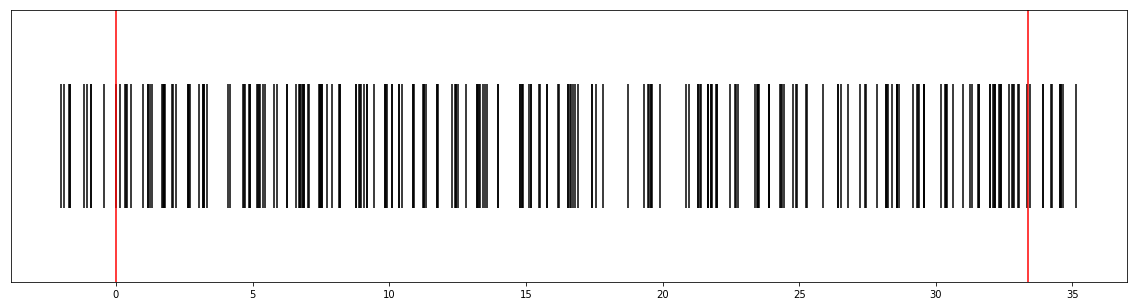

In [10]:
ntrials = len(trials)
spike_linewidth=1.5
spike_color='k'
ax = plt.gca()
ax.set_yticks(range(-1, ntrials-1))
ax.figure.set_size_inches(20, 5)
xposition = [0, stim_end_seconds]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='-')
ax.eventplot(raster_data, linewidths=spike_linewidth, colors=spike_color)

In [11]:
raster_data[0][250:258]

array([34.1981    , 34.25093333, 34.53273333, 34.5611    , 34.5682    ,
       34.5947    , 34.6654    , 35.12773333])

# Get toe data, toes

In [12]:
### make cluster_stim_data dataframe, one for each cluster
### each cluster has five stimuli
### name, ntrials, stim_start_times, stim_end_times, trial_start_times, trial_end_times, toes
d_stim = []
for i in range(len(clusters)):
    d_stim.append({'name':stim_data['name'], 'ntrials':stim_data['ntrials'], 'stim_start_times':stim_data['start_times'], 
                   'stim_end_times':stim_data['end_times'], 'trial_start_times':stim_data['trial_start'], 
                   'trial_end_times':stim_data['trial_end'], 'toes':raster_data})
cluster_stim_data = pd.DataFrame(d_stim)

In [21]:
cluster_stim_data.iloc[43:44]

,name,ntrials,stim_end_times,stim_start_times,toes,trial_end_times,trial_start_times


In [23]:
### make toe_data pandas dataframe, one for each cluster
### cluster id, sort class, fs, stims, all_spikes
d1 = []
for i in range(len(clusters)):
    ind = []
    ind = np.where(np.array(spikes['cluster']) == i+1)
    d1.append({'id':clusters['cluster'][i], 'sort_class':clusters['quality'][i], 'fs':30000, 
               'stims':cluster_stim_data[i:i+1], 'all_spikes':[spikes['time_samples'][j] for j in ind]})
#               'start_times':[trials['time_samples'][i] for i in ind], 'end_times':[trials['stimulus_end'][i] for i in ind], 
#                                                        'ntrials':(list(trials['stimulus'])).count(s)})
toe_data = pd.DataFrame(d1)

In [25]:
toe_data

,all_spikes,fs,id,sort_class,stims
0,"[[8, 593, 720, 933, 1792, 2980, 3079, 4142, 46...",30000,1,good,...
1,"[[675, 958, 3884, 4109, 4380, 4635, 4836, 5144...",30000,2,good,...
2,"[[234, 706, 1007, 1382, 1540, 2513, 2689, 2993...",30000,3,good,...
3,"[[1042, 1676, 1815, 2314, 2550, 2779, 3479, 42...",30000,4,good,...
4,"[[22641, 23792, 25435, 81748, 82934, 84451, 85...",30000,5,good,...
5,"[[610, 731, 1154, 1174, 1624, 2072, 2250, 2442...",30000,6,good,...
6,"[[425, 515, 772, 905, 1407, 1503, 2092, 2144, ...",30000,7,good,...
7,"[[1195, 1611, 2052, 2222, 3305, 3586, 4041, 42...",30000,8,good,...
8,"[[50, 188, 491, 653, 801, 832, 1073, 1099, 200...",30000,9,good,...
9,"[[3170, 4522, 5920, 6445, 7113, 9011, 11147, 1...",30000,10,good,...


# Stim prep

In [ ]:
### Get spectrogram
P1
P2
P3
P4
P5
P_all

In [ ]:
Nf = 16       # number of frequency bands in STRF
Nlags = 20    # number of times/lags
order   = 2   # order of MNE model to fit: order 1=linear part of equation,  order=2: linear and non linear parts
fittype = 0   # to intialize: 0 for regular fitting, 1 for random fitting  
njack   = 4
Nd = 4

# Resp prep

In [ ]:
cellnum = 21

In [ ]:
clear toes_B952_11
clear toes_B952_12
clear toes_B952_13
clear toes_B952_14
clear toes_B952_15

In [ ]:
resp_1=zeros(20, size(P1,2));
resp_2=zeros(20, size(P2,2));
resp_3=zeros(20, size(P3,2));
resp_4=zeros(20, size(P4,2));
resp_5=zeros(20, size(P5,2));

# Run MNE

In [ ]:
def plot_raster_cell__stim(spikes, trials, clusterID,
                          stim, period, rec, fs, ax=None, stim_ref='stim', **kwargs):
    stim_trials = trials[trials['stimulus'] == stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts) / fs)[0]
    if stim_ref == 'stim':
        window = [period[0], stim_end_seconds + period[1]]
    elif stim_ref == 'abs':
        window = [period[0], period[1]]
    raster_data = []
    for trial, start in enumerate(stim_starts):
        sptrain = get_spiketrain(rec, start, clusterID, spikes, window, fs)
        raster_data.append(sptrain)
    ax = do_raster(raster_data, window, [0, stim_end_seconds], ntrials, ax, **kwargs)
    return ax

AssertionError: []

In [ ]:
#

In [ ]:
import scipy.optimize as opt
import numpy as np

def log_loss(p, stim, resp, order):
    #get number of samples and dimensionality of stimulus
    Nsamples, Ndim = stim.shape
    resp = np.reshape(resp, (-1))
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0]
    h = p[1:Ndim+1].T
    
    #case: second order calculation --> need J
    if order > 1:
        #reshape J into Ndim x Ndim matrix:
        J = np.reshape(p[Ndim+1:Ndim+1+Ndim**2], (Ndim,Ndim)).T
    
    if order == 1:
        f1 = 1 + np.exp( a + stim.dot(h))
        f0 = 1 + np.exp(-a - stim.dot(h))
    else:
        f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
        f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
    
    F1 = resp * np.log(f1)
    F0 = (1 - resp) * np.log(f0)
    F1[np.isnan(F1)] = 0
    F0[np.isnan(F0)] = 0
    return np.mean(F0 + F1)

def d_log_loss(p,stim,avgs,order):
    #get number of samples and dimensionality of stimulus
    Nsamples, Ndim = stim.shape
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0]
    h = p[1:Ndim+1].T
    
    #case: second order calculation --> need J
    if order > 1:
        J = np.reshape(p[Ndim+1:Ndim+1+Ndim**2], (Ndim,Ndim))
        
    if order == 1:
        pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h))) #Nsamples x 1
        averages = np.hstack((np.mean(pSpike), stim.T.dot(pSpike) / Nsamples))
    elif order == 2:
        
        pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
        averages = np.zeros(1+Ndim+Ndim**2)
        averages[0] = np.mean(pSpike)
        averages[1:Ndim+1] = stim.T.dot(pSpike) / Nsamples #ave number of spikes for each stim dimension
        
        temp = (stim.T.dot(np.tile(np.reshape(pSpike, (Nsamples, 1)), (1,Ndim)) * stim)) / Nsamples  #ave number of spikes for each stim correlation
        temp = np.reshape(temp,[Ndim**2,1])
        averages[Ndim+1:Ndim+1+Ndim**2] = np.reshape(temp, Ndim**2)
        
    return (np.squeeze(avgs) - averages)

def constrained_averages(stim, resp, order):
    Nsamples, Ndim = stim.shape
    psp = np.mean(resp) #spike probability
    avg = stim.T.dot(resp) / Nsamples
    avgs = np.vstack((psp,avg))
    if order > 1 :
        avgsqrd = stim.T.dot(np.tile(resp, (1,Ndim)) * stim) / Nsamples
        avgsqrd = np.reshape(avgsqrd,(Ndim**2,1))
        avgs = np.vstack((avgs,avgsqrd))
    return avgs

def rand_pstart(avgs, order, Ndim):
    pstart = np.log(1.0 / avgs[0] - 1.0)
    pstart = np.hstack((pstart,(.001*(2*np.random.rand(Ndim)-1))))
    if order > 1:
        temp = .0005 * (2 * np.random.rand(Ndim,Ndim) - 1) # for symmetry
        pstart = np.hstack((pstart, np.reshape(temp + temp.T, Ndim**2)))
    return pstart
    
class IterCounter(object):
    def __init__(self):
        self.n_iters = 1
        print '{0:5s}'.format('Iters')
    def callback(self, xk):
        print '{0:5d}'.format(self.n_iters)
        self.n_iters += 1
    
class OverfitException(Exception):
    def __init__(self, p):
        self.p = p
        
class OverfitStopper(object):
    def __init__(self, test_stim, test_resp, order):
        self.test_stim = test_stim
        self.test_resp = test_resp
        self.order = order
        self.n_iters = 1
        self.best_ll = np.inf
        self.best_p = 0
        self.test_tally = 0
        print '{0:5s}   {1:5s}   {2:9s}'.format('Iters', 'tally', 'll(test)')
        
    def callback(self, pk):
        ll_test_k = log_loss(pk, self.test_stim, self.test_resp, self.order)
        print '{0:5d}   {1:5d}   {2: 3.6f}'.format(self.n_iters, self.test_tally, ll_test_k)
        if self.n_iters <= 2 or ll_test_k < self.best_ll:
            self.best_ll = ll_test_k
            self.best_p = pk
            self.test_tally = 0
        else:
            self.test_tally += 1
        
        if self.test_tally >= 10:
            print 'minimum of test set found'
            raise OverfitException(self.best_p)
        
        self.n_iters += 1

def MNEfit(stim, resp, order, pstart=None):

    stim = np.array(stim, dtype=float)
    resp = np.array(resp, dtype=float)

    Nsamples, Ndim = stim.shape
    avgs = constrained_averages(stim, resp, order)
    
    if pstart is None: #initialize params:
        pstart = rand_pstart(avgs, order, Ndim)
    
    #redefine functions with fixed vals:
    def logLoss(p):
        return log_loss(p, stim, resp, order)
    def dlogLoss(p):
        return d_log_loss(p, stim, avgs, order)
    
    pfinal = opt.fmin_cg(logLoss, pstart, fprime=dlogLoss, 
                         callback=IterCounter().callback, maxiter=200)
    
    return pfinal

def MNEfit_jackknives(stim, resp, order, pstart=None, jackknives=4, shuffle=True):

    stim = np.array(stim, dtype=float)
    resp = np.array(resp, dtype=float)
    
    Nsamples, Ndim = stim.shape #TODO: rename Nsamples to n_samples
    assert resp.shape[0] == Nsamples
    assert resp.shape[1] == 1
    
    if shuffle:
        shuffled_indxs = range(Nsamples)
        np.random.shuffle(shuffled_indxs)
        stim = stim[shuffled_indxs,:]
        resp = resp[shuffled_indxs,:]
    
    for jackknife in range(jackknives):
        test_stim = stim[jackknife::jackknives,:]
        test_resp = resp[jackknife::jackknives,:]
        train_stim = stim[np.mod(np.arange(Nsamples)-jackknife, jackknives) != 0,:]
        train_resp = resp[np.mod(np.arange(Nsamples)-jackknife, jackknives) != 0,:]
        
        avgs = constrained_averages(train_stim, train_resp, order)

        if pstart is None: #initialize params:
            pstart = rand_pstart(avgs, order, Ndim)
            
        #redefine functions with fixed vals:
        def logLoss(p):
            return log_loss(p, train_stim, train_resp, order)
        def dlogLoss(p):
            return d_log_loss(p, train_stim, avgs, order)

        try:
            pfinal = opt.fmin_cg(logLoss, pstart, fprime=dlogLoss,
                                 callback=OverfitStopper(test_stim, test_resp, order).callback,
                                 maxiter=200)
        except OverfitException as e:
            pfinal = e.p
        
        if jackknife == 0:
            all_pfinals = np.zeros((jackknives, len(pstart)))
        all_pfinals[jackknife, :] = pfinal
    
    return all_pfinals